In [1]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19, VGG16

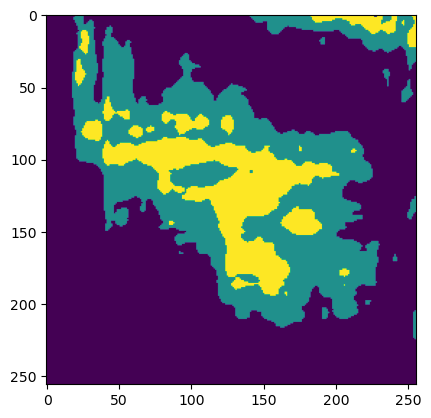

In [7]:
def create_image(image_path):
    # Load the terahertz image
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image_array = np.array(image)
    normalized_image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

    return normalized_image_array

def fill_tumor_regions(image):
    # Copy the image to prevent modification of the original
    filled_image = image.copy()
    
    # Find contours in the image
    contours, _ = cv2.findContours(filled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Iterate through each contour and fill the region
    for contour in contours:
        cv2.drawContours(filled_image, [contour], 0, 255, -1)
    
    return filled_image

def create_tumor_mask_3(image_path):
    # Load the terahertz image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color thresholds for tumor, non-tumor, and third-class regions
    tumor_lower = np.array([0, 0, 0], dtype=np.uint8)  # Darker colors
    tumor_upper = np.array([20, 255, 255], dtype=np.uint8)  # Brighter colors than orange
    
    non_tumor_lower = np.array([20, 50, 50], dtype=np.uint8)  # Yellow, sky blue, and light green colors
    non_tumor_upper = np.array([90, 255, 255], dtype=np.uint8)
    
    # Create the initial tumor mask based on the color thresholds
    tumor_mask = cv2.inRange(hsv_image, tumor_lower, tumor_upper)
    
    # Create the mask for the non-tumor class
    non_tumor_mask = cv2.inRange(hsv_image, non_tumor_lower, non_tumor_upper)
    
    # Combine the tumor mask and non-tumor mask
    combined_mask = cv2.bitwise_or(tumor_mask, non_tumor_mask)
    
    # Perform region filling to include missing parts in the tumor class
    tumor_mask_filled = fill_tumor_regions(combined_mask)
    
    # Create the final mask with three classes (0, 1, 2)
    mask = np.zeros_like(tumor_mask_filled)
    mask[tumor_mask_filled == 255] = 2  # Tumor class
    mask[non_tumor_mask == 255] = 1  # Non-tumor class
    
    return mask


# image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG\\B_top_ImgAdj.jpg"
# image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\img_output_gamma\\B_top_ImgAdj.jpg"
image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\img_processed_1.8gamma\\B_bot_ImgAdj_processed.jpg"
tumor_mask = create_tumor_mask_3(image_path)
plt.imshow(tumor_mask)

In [8]:
def one_hot_encode(mask):
    # Create an empty array of shape (256, 256, 3) for the one-hot encoded mask
    one_hot_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    
    one_hot_mask[mask == 0, 0] = 1  # Background class (0)
    one_hot_mask[mask == 1, 1] = 1  # Non-tumor class (1)
    one_hot_mask[mask == 2, 2] = 1  # Tumor class (2)
    
    return one_hot_mask

In [9]:
def decode_one_hot(one_hot_mask):
    # Find the channel with the maximum value for each pixel
    mask = np.argmax(one_hot_mask, axis=-1)
    return mask

Encoded Mask shape :  (256, 256, 3)
Decoded Mask shape :  (256, 256)


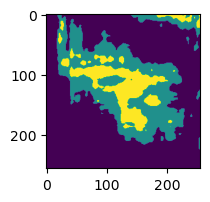

In [10]:
# checking that both the encoder and decoder function works correctly
plt.figure(figsize = (2,2))
encoded_mask = one_hot_encode(tumor_mask)
print("Encoded Mask shape : ",encoded_mask.shape)
decoded_mask = decode_one_hot(encoded_mask)
print("Decoded Mask shape : ",decoded_mask.shape)
plt.imshow(decoded_mask)

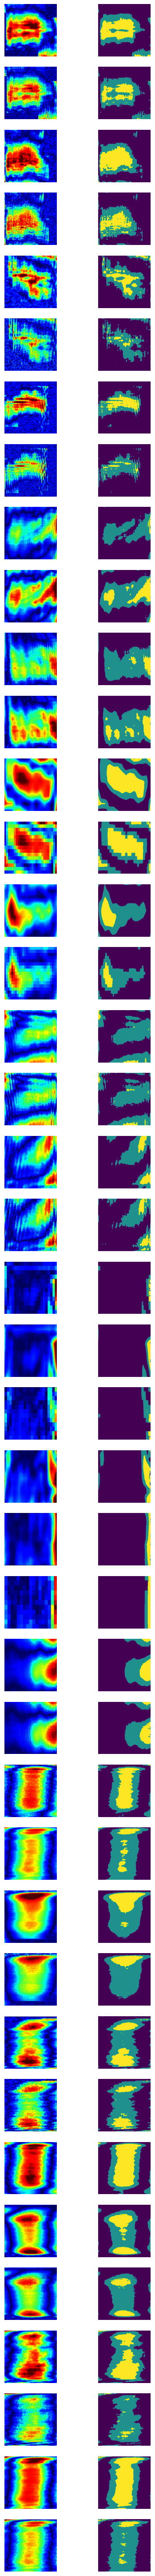

In [11]:
image_folder = 'C:\\Users\\apurv\\Desktop\\CSIR\\img_processed_1.8gamma'
image_files = os.listdir(image_folder)
masks = []
images = []
fig, ax = plt.subplots(len(os.listdir(image_folder)), 2, figsize=(5, 75))
for i in range(len(os.listdir(image_folder))):
    fp = os.path.join(image_folder,image_files[i])
    mask = create_tumor_mask_3(fp)
    masks.append(one_hot_encode(mask))
    image = create_image(fp)
    images.append(image)
    ax[i][0].set_axis_off()
    ax[i][1].set_axis_off()
    ax[i][0].imshow(image)
    ax[i][1].imshow(mask)

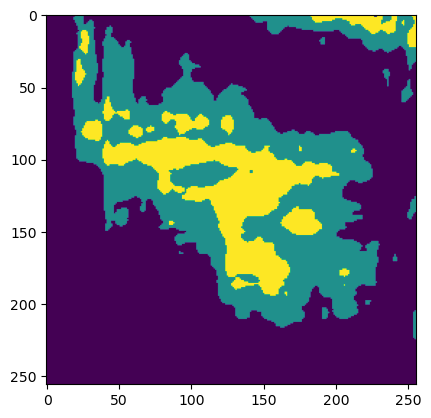

In [12]:
plt.imshow(decode_one_hot(masks[4]))

In [13]:
masks = np.array(masks)
images = np.array(images)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=10)
print("Train Shape : ", X_train.shape)
print("y Train Shape : ", y_train.shape)
print("Test Shape : ", X_test.shape)
print("y Test Shape : ", y_test.shape)

Train Shape :  (32, 256, 256, 3)
y Train Shape :  (32, 256, 256, 3)
Test Shape :  (9, 256, 256, 3)
y Test Shape :  (9, 256, 256, 3)


In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape, num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

# Assuming 3 classes (change this value accordingly)
num_classes = 3
model = build_vgg19_unet((256, 256, 3), num_classes)
model.summary()


Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 256)  590080      ['activation_2[0][0]']           
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 64, 64, 256)  0           ['batch_normalization_3[0][0]']  
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 12  131200     ['activation_3[0][0]']           
 spose)                         8)                                                                
          

In [16]:
def org_iou(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    return (true_pos )/(true_pos + false_neg + false_pos)

In [17]:
def decode_one_hot_t(one_hot_mask):
    # Find the channel with the maximum value for each pixel
    mask = tf.argmax(one_hot_mask, axis=-1)
    return mask

def iou_new(y_true, y_pred):
    y_t = decode_one_hot_t(y_true)
    y_p = decode_one_hot_t(y_pred)
    
    return org_iou(y_t, y_p)

In [18]:
def iou(y_true, y_pred):
    # Flatten y_true and y_pred for all classes
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Calculate true positive, false negative, and false positive for each class
    true_pos = []
    false_neg = []
    false_pos = []
    for class_idx in range(3):
        true_pos_class = K.sum(y_true_flat[..., class_idx] * y_pred_flat[..., class_idx])
        false_neg_class = K.sum(y_true_flat[..., class_idx] * (1 - y_pred_flat[..., class_idx]))
        false_pos_class = K.sum((1 - y_true_flat[..., class_idx]) * y_pred_flat[..., class_idx])

        true_pos.append(true_pos_class)
        false_neg.append(false_neg_class)
        false_pos.append(false_pos_class)

    # Calculate IoU for each class and return the average IoU
    iou_per_class = [true_pos[i] / (true_pos[i] + false_neg[i] + false_pos[i] + K.epsilon()) for i in range(3)]
    iou_tensor = K.stack(iou_per_class)  # Convert the list to a tensor
    return K.mean(iou_tensor)


In [19]:
def new_iou(y_true, y_pred):
    iou_scores = []
    for class_id in range(3):  # Assuming you have 3 classes
        y_true_pos = K.cast(K.equal(y_true, class_id), K.floatx())
        y_pred_pos = K.cast(K.equal(y_pred, class_id), K.floatx())
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        iou_scores.append(true_pos / (true_pos + false_neg + false_pos))
    
    mean_iou = K.mean(K.stack(iou_scores))
    return mean_iou

In [20]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy', org_iou]
                 )

checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [21]:
history = model.fit(X_train, y_train ,
                    epochs = 150,
                    validation_data = (X_test, y_test),
                    callbacks = [checkpointer, reduce_lr]
                 )

Epoch 1/150
1/1 [==============================] - 48s 48s/step - loss: 1.3140 - accuracy: 0.2725 - org_iou: 0.1898 - val_loss: 2.0401 - val_accuracy: 0.3018 - val_org_iou: 0.1769 - lr: 0.0500
Epoch 2/150
1/1 [==============================] - 60s 60s/step - loss: 0.4592 - accuracy: 0.8855 - org_iou: 0.5008 - val_loss: 1.5259 - val_accuracy: 0.3445 - val_org_iou: 0.2482 - lr: 0.0500
Epoch 3/150
1/1 [==============================] - 47s 47s/step - loss: 0.2782 - accuracy: 0.9506 - org_iou: 0.6429 - val_loss: 1.1500 - val_accuracy: 0.3452 - val_org_iou: 0.3028 - lr: 0.0500
Epoch 4/150
1/1 [==============================] - 51s 51s/step - loss: 0.2082 - accuracy: 0.9649 - org_iou: 0.7139 - val_loss: 0.8706 - val_accuracy: 0.3851 - val_org_iou: 0.3702 - lr: 0.0500
Epoch 5/150
1/1 [==============================] - 37s 37s/step - loss: 0.1705 - accuracy: 0.9701 - org_iou: 0.7581 - val_loss: 0.6763 - val_accuracy: 0.6146 - val_org_iou: 0.4440 - lr: 0.0500
Epoch 6/150
1/1 [==================

1/1 [==============================] - 51s 51s/step - loss: 0.0450 - accuracy: 0.9882 - org_iou: 0.9405 - val_loss: 0.1228 - val_accuracy: 0.9709 - val_org_iou: 0.8639 - lr: 0.0500
Epoch 44/150
1/1 [==============================] - 37s 37s/step - loss: 0.0447 - accuracy: 0.9883 - org_iou: 0.9411 - val_loss: 0.1211 - val_accuracy: 0.9715 - val_org_iou: 0.8646 - lr: 0.0500
Epoch 45/150
1/1 [==============================] - 46s 46s/step - loss: 0.0444 - accuracy: 0.9884 - org_iou: 0.9417 - val_loss: 0.1195 - val_accuracy: 0.9721 - val_org_iou: 0.8654 - lr: 0.0500
Epoch 46/150
1/1 [==============================] - 50s 50s/step - loss: 0.0441 - accuracy: 0.9884 - org_iou: 0.9422 - val_loss: 0.1180 - val_accuracy: 0.9725 - val_org_iou: 0.8661 - lr: 0.0500
Epoch 47/150
1/1 [==============================] - 41s 41s/step - loss: 0.0438 - accuracy: 0.9885 - org_iou: 0.9427 - val_loss: 0.1166 - val_accuracy: 0.9729 - val_org_iou: 0.8669 - lr: 0.0500
Epoch 48/150
1/1 [=========================

1/1 [==============================] - 36s 36s/step - loss: 0.0368 - accuracy: 0.9899 - org_iou: 0.9543 - val_loss: 0.0698 - val_accuracy: 0.9843 - val_org_iou: 0.9063 - lr: 0.0500
Epoch 86/150
1/1 [==============================] - 35s 35s/step - loss: 0.0367 - accuracy: 0.9899 - org_iou: 0.9545 - val_loss: 0.0691 - val_accuracy: 0.9844 - val_org_iou: 0.9071 - lr: 0.0500
Epoch 87/150
1/1 [==============================] - 35s 35s/step - loss: 0.0366 - accuracy: 0.9899 - org_iou: 0.9548 - val_loss: 0.0685 - val_accuracy: 0.9845 - val_org_iou: 0.9078 - lr: 0.0500
Epoch 88/150
1/1 [==============================] - 40s 40s/step - loss: 0.0364 - accuracy: 0.9900 - org_iou: 0.9550 - val_loss: 0.0679 - val_accuracy: 0.9846 - val_org_iou: 0.9085 - lr: 0.0500
Epoch 89/150
1/1 [==============================] - 35s 35s/step - loss: 0.0363 - accuracy: 0.9900 - org_iou: 0.9552 - val_loss: 0.0673 - val_accuracy: 0.9847 - val_org_iou: 0.9092 - lr: 0.0500
Epoch 90/150
1/1 [=========================

1/1 [==============================] - 47s 47s/step - loss: 0.0320 - accuracy: 0.9911 - org_iou: 0.9617 - val_loss: 0.0523 - val_accuracy: 0.9863 - val_org_iou: 0.9305 - lr: 0.0500
Epoch 128/150
1/1 [==============================] - 60s 60s/step - loss: 0.0319 - accuracy: 0.9911 - org_iou: 0.9618 - val_loss: 0.0521 - val_accuracy: 0.9863 - val_org_iou: 0.9310 - lr: 0.0500
Epoch 129/150
1/1 [==============================] - 47s 47s/step - loss: 0.0318 - accuracy: 0.9911 - org_iou: 0.9619 - val_loss: 0.0518 - val_accuracy: 0.9863 - val_org_iou: 0.9315 - lr: 0.0500
Epoch 130/150
1/1 [==============================] - 37s 37s/step - loss: 0.0317 - accuracy: 0.9912 - org_iou: 0.9621 - val_loss: 0.0515 - val_accuracy: 0.9863 - val_org_iou: 0.9320 - lr: 0.0500
Epoch 131/150
1/1 [==============================] - 36s 36s/step - loss: 0.0316 - accuracy: 0.9912 - org_iou: 0.9622 - val_loss: 0.0512 - val_accuracy: 0.9862 - val_org_iou: 0.9325 - lr: 0.0500
Epoch 132/150
1/1 [====================

In [22]:
tf.keras.models.save_model(model,'th3gamma1.8class_model.h5')

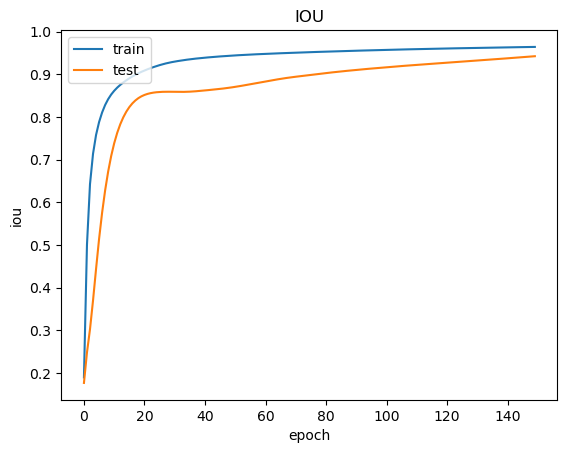

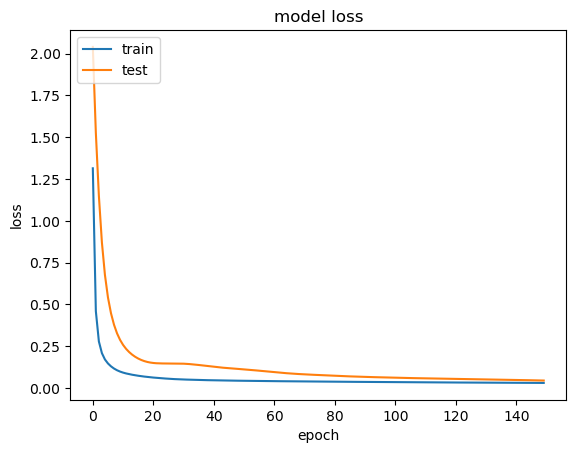

In [23]:
plt.plot(history.history['org_iou'])
plt.plot(history.history['val_org_iou'])
plt.title('IOU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
pred_3_channel = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [25]:
pred = np.argmax(pred_3_channel, axis = -1)
pred.shape

(9, 256, 256)

In [26]:
ground_mask = np.argmax(y_test, axis = -1)

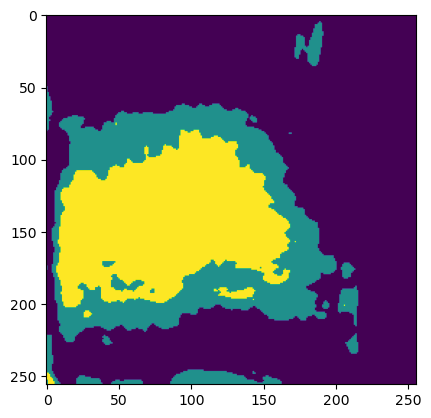

In [27]:
plt.imshow(ground_mask[3])

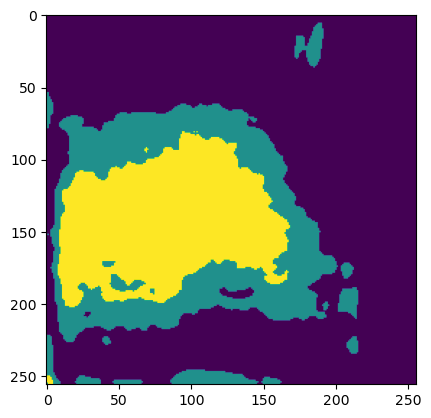

In [28]:
plt.imshow(pred[3])

In [29]:
pred.shape

(9, 256, 256)

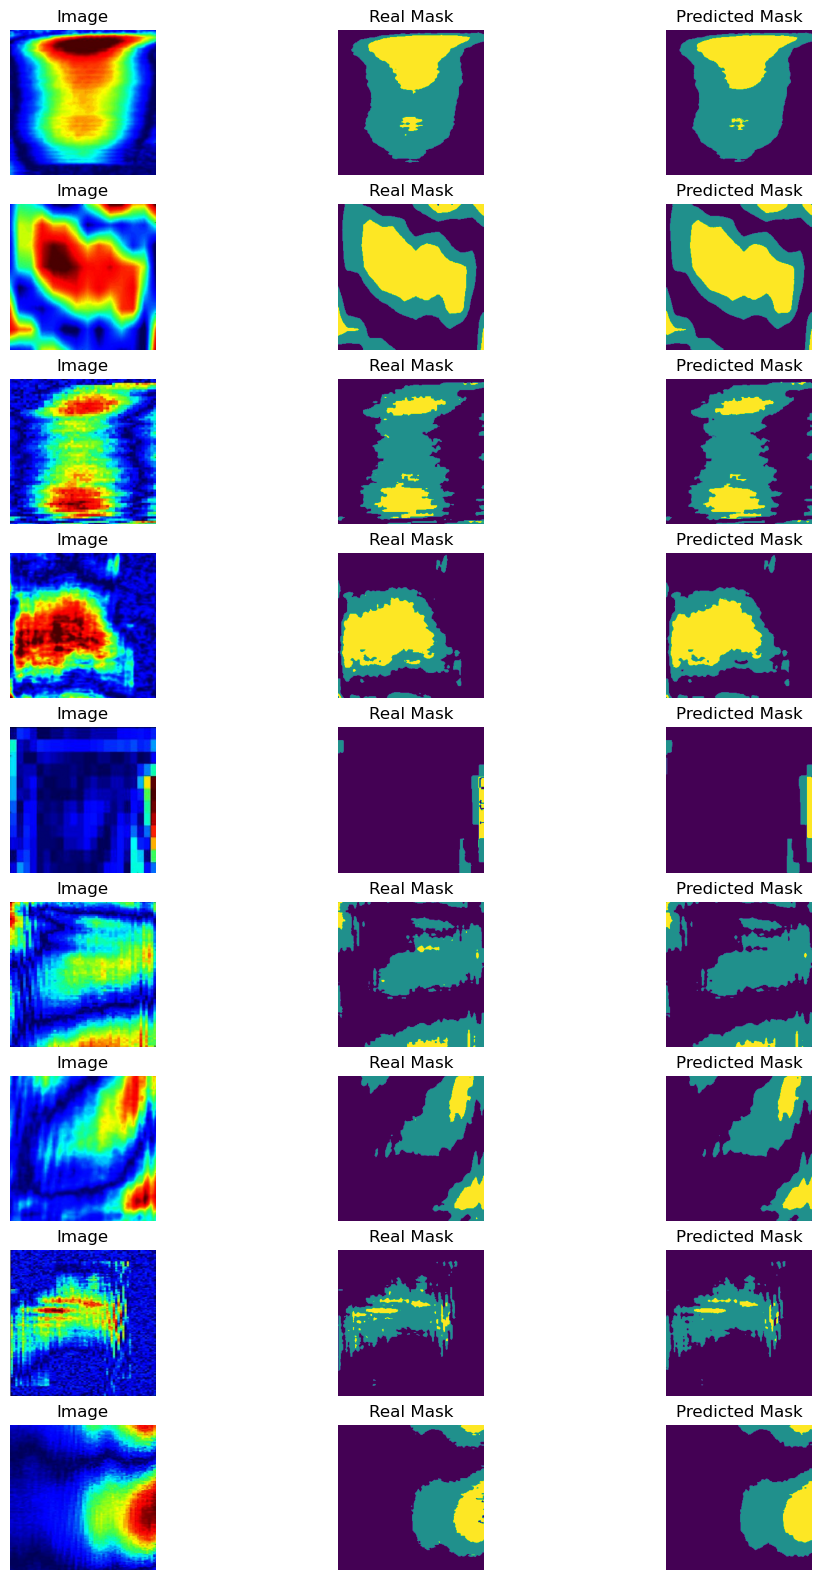

In [30]:
fig, ax = plt.subplots(9, 3, figsize=(12,20))
for i in range(pred.shape[0]):
    pred_mask_array = pred[i]
    img_array = X_test[i]
    mask_array = ground_mask[i]
    
    ax[i][0].imshow(img_array)
    ax[i][0].set_title("Image")
    ax[i][0].axis('off')
    ax[i][1].imshow(mask_array)
    ax[i][1].axis('off')
    ax[i][1].set_title("Real Mask")
    ax[i][2].axis('off')
    ax[i][2].imshow(pred_mask_array)
    ax[i][2].set_title("Predicted Mask")


In [31]:
def giveIoU(y_true, y_pred):
    m = tf.keras.metrics.MeanIoU(num_classes=3)
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [32]:
def giveAccuracy(y_true, y_pred):
    m = tf.keras.metrics.Accuracy()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [33]:
def giveIoUclasswise(y_true, y_pred):
    m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [34]:
classes = ["Background", "Non Tumor", "Tumor"]
def confusion_matrix(y_true, y_pred, class_label):
    return np.sum((y_true == class_label) & (y_pred == class_label))

def class_iou(y_true, y_pred, class_label):
    tp = confusion_matrix(y_true, y_pred, class_label)
    fp = np.sum((y_true != class_label) & (y_pred == class_label))
    fn = np.sum((y_true == class_label) & (y_pred != class_label))
    
    iou = tp / (tp + fp + fn + 1e-6) 
    return iou

def classwise_ious(y_true, y_pred, num_classes=3):
    class_ious = {}
    for class_label in range(num_classes):
        iou = class_iou(y_true, y_pred, class_label)
        class_ious[f'IoU {classes[class_label]}'] = iou
    return class_ious

In [35]:
def give_dice_coefficient(y_true, y_pred, num_classes=3, smooth=1e-6):
    # Ensure masks are integer type and within the range of [0, num_classes - 1]
    y_true = np.asarray(y_true, dtype=np.int64)
    y_pred = np.asarray(y_pred, dtype=np.int64)
    y_true = np.clip(y_true, 0, num_classes - 1)
    y_pred = np.clip(y_pred, 0, num_classes - 1)

    dice_per_class = []

    for i in range(num_classes):
        y_true_class = (y_true == i)
        y_pred_class = (y_pred == i)

        intersection = np.logical_and(y_true_class, y_pred_class).sum()
        union = y_true_class.sum() + y_pred_class.sum()

        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        dice_per_class.append(dice_score)

    # Calculate the average Dice coefficient across all classes
    average_dice_score = np.mean(dice_per_class)

    return average_dice_score


In [36]:
for i in range(pred.shape[0]):
    pred_mask_array = pred[i]
    mask_array = ground_mask[i]
    print("Image",i+1,": ")
    print("PixelWise Accuracy :", giveAccuracy(mask_array, pred_mask_array))
    print(classwise_ious(mask_array, pred_mask_array))
    print("Mean IoU :", giveIoU(mask_array, pred_mask_array))
    print("Dice coefficient :",give_dice_coefficient(mask_array, pred_mask_array))
    print()

Image 1 : 
PixelWise Accuracy : 0.9853668
{'IoU Background': 0.9942256393850862, 'IoU Non Tumor': 0.9604601302481875, 'IoU Tumor': 0.9253084039200743}
Mean IoU : 0.9599981
Dice coefficient : 0.9793803926157256

Image 2 : 
PixelWise Accuracy : 0.9881897
{'IoU Background': 0.9908529524897394, 'IoU Non Tumor': 0.9642339519863372, 'IoU Tumor': 0.9712797853363169}
Mean IoU : 0.9754556
Dice coefficient : 0.9875424963232673

Image 3 : 
PixelWise Accuracy : 0.98350525
{'IoU Background': 0.9841079543596033, 'IoU Non Tumor': 0.9580121030855503, 'IoU Tumor': 0.9125905795723745}
Mean IoU : 0.9515702
Dice coefficient : 0.9749480263203493

Image 4 : 
PixelWise Accuracy : 0.9873352
{'IoU Background': 0.9887009877035643, 'IoU Non Tumor': 0.9461221954082663, 'IoU Tumor': 0.961696408499836}
Mean IoU : 0.96550655
Dice coefficient : 0.9823693163723387

Image 5 : 
PixelWise Accuracy : 0.99508667
{'IoU Background': 0.9951935442226852, 'IoU Non Tumor': 0.9292470673744809, 'IoU Tumor': 0.8430983109800414}
Mea